In [1]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

In [2]:
import random
import sklearn
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt


In [3]:
data_path = "Data/Training/combined.csv"
df = pd.read_csv(data_path)

In [4]:
df.dropna()

,content,topic,label
0,"In Python, all exceptions must be instances of...",Built-in Exceptions,0
1,In a try statement with an except clause tha...,Built-in Exceptions,0
2,Two exception classes that are not related v...,Built-in Exceptions,0
3,The built-in exceptions listed below can be g...,Built-in Exceptions,0
4,"Except where mentioned, they have an “associ...",Built-in Exceptions,0
...,...,...,...
293,"The module defines several functions, constan...",regex,3
294,Some of the functions are simplified versions...,regex,3
295,Most non-trivial applications always use the...,regex,3
296,Compiled regular expression objects support t...,regex,3


In [21]:
# Split the data into train and test
train, val = train_test_split(df, test_size=0.2, random_state=42)

False

In [55]:
data_path = "Data/Test/combined.csv"
df2 = pd.read_csv(data_path)

In [56]:
df2

,Id,Body,Title,Tags,text,label
0,166198,I'm writing a little debug app for a bit of ki...,How can I capture all exceptions from a wxPyth...,<python><exception><error-handling><wxwidgets>...,How can I capture all exceptions from a wxPyth...,0
1,1291438,"From this question, I'm now doing error handli...","When I catch an exception, how do I get the ty...",<python><exception><exception-handling><error-...,"When I catch an exception, how do I get the ty...",0
2,1350671,My background is in C# and I've just recently ...,"""Inner exception"" (with traceback) in Python?",<python><exception><error-handling>,"""Inner exception"" (with traceback) in Python? ...",0
3,1483429,How do I print the error/exception in the blo...,How do I print an exception in Python?,<python><exception><error-handling>,How do I print an exception in Python? How do ...,0
4,1508467,How can I log my Python exceptions?,Log exception with traceback in Python,<python><exception><logging><error-handling>,Log exception with traceback in Python How can...,0
...,...,...,...,...,...,...
386,4221534,Given string I would like to get this output...,python regex grouping,<python><regex>,python regex grouping Given string I would l...,3
387,1836637,I am doing simple regular expressions in pytho...,python help display regular expression result,<python><regex>,python help display regular expression result ...,3
388,64247233,I'm struggling to write a regex that extracts ...,"Regex ""AND"" in an expression extract this and ...",<python><regex>,"Regex ""AND"" in an expression extract this and ...",3
389,63770358,I have a weird column named in a dataframe th...,Fill missing values in selected columns with f...,<python><regex><pandas><null><fillna>,Fill missing values in selected columns with f...,3


In [7]:
#keep the body and the title of df2
df2 = df2[['Body', 'Title']]
df2['label']=[0,1]

In [10]:
#rename the body column to content
df2.rename(columns={'Body':'Content'}, inplace=True)

In [5]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "Data/Training/combined.csv"
        df = pd.read_csv(data_path)
        df=df.dropna()
        train, val = train_test_split(df, test_size=0.2, random_state=42)

        if split == "train":
            df=train
        elif split == "val":
            df=val
    
        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i,row in df.iterrows():
            L = row['content'].split()
            while len(L)<4:
                L.append('<pad>')
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row['label'])
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

In [63]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, vocab,partition):
        data_path = "Data/Test/combined.csv"
        df = pd.read_csv(data_path)
    
        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i,row in df.iterrows():
            L = row[partition].split()
            while len(L)<4:
                L.append('<pad>')
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row['label'])
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 

In [6]:
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=100)    # embedding size = 50

#Upload datasets

In [7]:
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [66]:
torch.manual_seed(2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
#glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
# 3.3.2
train_dataset = TextDataset(glove, 'train')
val_dataset = TextDataset(glove, "val")
test_dataset = TestDataset(glove,'text')
#overfit_dataset= TextDataset(glove, "overfit")
    
# 3.3.3
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))
validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))
#overfit_dataloader = torch.utils.data.DataLoader(
        #dataset=overfit_dataset,
        #batch_size=1,
        #shuffle=False,
        #collate_fn=lambda batch: my_collate_function(batch, device))

Using device: cuda


#Create CNN Model

In [47]:
class CNNModel(torch.nn.Module): # CNN model # 4 classes
    def __init__(self, vocab, n1,n2, k1,k2):
        super().__init__()
        # initialize word vectors to random numbers 
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)
        self.conv1=torch.nn.Conv2d(1,n1,(100,k1),bias=False)
        self.conv2=torch.nn.Conv2d(1,n2,(100,k2),bias=False)
        self.activate=torch.nn.ReLU()
        self.maxpool= torch.nn.MaxPool2d((1,500),ceil_mode=True)
        #self.maxpool2= torch.nn.MaxPool1d()
        self.dropout = torch.nn.Dropout(0.25)
        self.out1= torch.nn.Linear(n1+n2,50)
        self.out2= torch.nn.Linear(50,4)
        self.softmax = torch.nn.Softmax()
        #TO DO
        
        # prediction function takes embedding as input, and predicts which word in vocabulary as output

        #TO DO
        
    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        #TO DO
        #print(x.size())
        embed=self.embedding(x)
        #print(embed.size())
        embed=embed.T.unsqueeze(0)
        #print(embed.size())
        conv1=self.conv1(embed)
        conv1=self.activate(conv1)
        conv2=self.conv2(embed)
        conv2=self.activate(conv2)
        #conv1=conv1.squeeze()
        #conv2=conv2.squeeze()
        #print(conv1.size())
        #print(conv2.size())
        max1= self.maxpool(conv1)
        #print(max1.size())
        max2=self.maxpool(conv2)
        #print(max2.size())
        drop=self.dropout(torch.cat((max1,max2)).squeeze())
        #output=self.out(drop)
        output=self.out1(drop) #torch.cat((max1,max2)).squeeze()
        output=self.out2(output)
        output=self.softmax(output)
        return output

#Test Model On Overfit dataset

In [14]:
model1=CNNModel(glove,50,50,2,4)

In [15]:
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_losses=[]
val_losses=[]
train_acc_arr=[]
val_acc_arr=[]

epoch= 0
train loss= 1.2019902975298464
train_acc 0.58
validation error= 0.7038939661905169
val_acc for epoch 0.5
epoch= 1
train loss= 0.7235196366906166
train_acc 0.48
validation error= 0.6432537998910993
val_acc for epoch 0.58875
epoch= 2
train loss= 0.5179372383654117
train_acc 0.86
validation error= 0.6414191784150899
val_acc for epoch 0.545625
epoch= 3
train loss= 0.44392816949635744
train_acc 0.9
validation error= 0.6075373819400557
val_acc for epoch 0.623125
epoch= 4
train loss= 0.3281937803328037
train_acc 0.96
validation error= 0.5806550324958516
val_acc for epoch 0.67375
epoch= 5
train loss= 0.2244008158147335
train_acc 0.96
validation error= 0.556999356803717
val_acc for epoch 0.7125
epoch= 6
train loss= 0.15037747632712126
train_acc 1.0
validation error= 0.5135681892211141
val_acc for epoch 0.7725
epoch= 7
train loss= 0.09411447001853958
train_acc 1.0
validation error= 0.48664110297650043
val_acc for epoch 0.79
epoch= 8
train loss= 0.06069689717958681
train_acc 1.0
validati

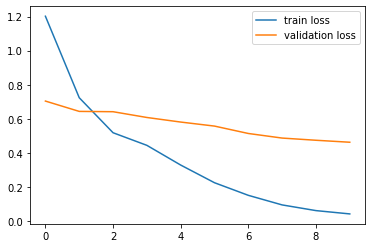

In [11]:
for epoch in range(10):  # loop over the dataset multiple times

    train_loss = 0.0
    val_loss=0
    train_acc=0
    val_acc=0
    model1.train()
    print('epoch=', epoch)
    
    for inputs, labels in overfit_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs.flatten())
        #print(outputs)
        #print(labels)
        loss = loss_func(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        train_acc+=torch.sum(((outputs>0)== labels)[:].int()).item()
    train_loss=train_loss/len(overfit_dataset)
    train_losses.append(train_loss)
    print('train loss=',train_loss)
    train_acc=train_acc/len(overfit_dataset)
    train_acc_arr.append(train_acc)
    print('train_acc',train_acc)


    model1.eval()
    for inputs, labels in validation_dataloader:

      pred=model1(inputs.flatten())
      loss = loss_func(pred, labels.float())
      val_loss+= loss.item()
      val_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
    val_loss=val_loss/len(val_dataset)
    val_losses.append(val_loss)
    print('validation error=',val_loss)
    val_acc=val_acc/len(val_dataset)
    val_acc_arr.append(val_acc)
    print('val_acc for epoch',val_acc)


print('Finished Training')
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

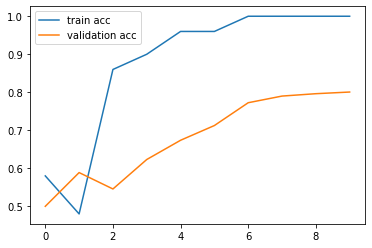

In [12]:
plt.plot(train_acc_arr, label='train acc')
plt.plot(val_acc_arr, label='validation acc')
plt.legend()
plt.show()

#Hyperparameter tuning of the CNN model 

In [49]:
model1=CNNModel(glove,25,25,2,3)
model1.to(torch.device('cuda:0'))

CNNModel(
  (embedding): Embedding(400000, 100)
  (conv1): Conv2d(1, 25, kernel_size=(100, 2), stride=(1, 1), bias=False)
  (conv2): Conv2d(1, 25, kernel_size=(100, 3), stride=(1, 1), bias=False)
  (activate): ReLU()
  (maxpool): MaxPool2d(kernel_size=(1, 500), stride=(1, 500), padding=0, dilation=1, ceil_mode=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (out1): Linear(in_features=50, out_features=50, bias=True)
  (out2): Linear(in_features=50, out_features=4, bias=True)
  (softmax): Softmax(dim=None)
)

In [50]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
train_losses=[]
val_losses=[]
train_acc_arr=[]
val_acc_arr=[]

epoch= 0


d:\SOFTWARE\Anaconda3\envs\ece1786\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train loss= 1.1285013581524377
train_acc 0.6848739495798319
validation error= 1.185766303539276
val_acc for epoch 0.6333333333333333
epoch= 1
train loss= 1.1077659693585724
train_acc 0.6974789915966386
validation error= 1.1786297212044399
val_acc for epoch 0.6166666666666667
epoch= 2
train loss= 1.095777477286443
train_acc 0.7184873949579832
validation error= 1.1678736358880997
val_acc for epoch 0.6166666666666667
epoch= 3
train loss= 1.0835925062664418
train_acc 0.7100840336134454
validation error= 1.1605160713195801
val_acc for epoch 0.6166666666666667
epoch= 4
train loss= 1.0698932539515134
train_acc 0.7226890756302521
validation error= 1.1538793375094731
val_acc for epoch 0.6166666666666667
epoch= 5
train loss= 1.0519853161663568
train_acc 0.7394957983193278
validation error= 1.1462766398986182
val_acc for epoch 0.6166666666666667
epoch= 6
train loss= 1.052542771611895
train_acc 0.7352941176470589
validation error= 1.1386863231658935
val_acc for epoch 0.6333333333333333
epoch= 7
tr

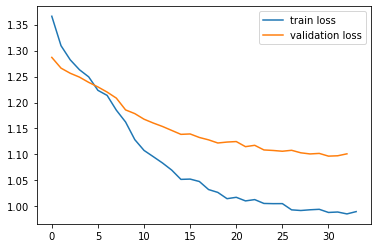

In [53]:
for epoch in range(25):  # loop over the dataset multiple times

    train_loss = 0.0
    val_loss=0
    train_acc=0
    val_acc=0
    model1.train()
    print('epoch=', epoch)
    
    for inputs, labels in train_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs.flatten())
        #print(outputs)
        #print(labels)
        #print('raw output',outputs)
        outputs_hard=outputs.argmax()
        outputs=outputs.unsqueeze(0)
        #labels=labels.unsqueeze(0)
        #print('labels',labels)
        #print('armax output',outputs_hard)
        #print('output shape',outputs.shape)
        #print('label ahape',labels.shape)
        loss = loss_func(outputs, labels)
        #print('loss',loss)
        #print('loss shape',loss.shape)
        loss.backward()
        optimizer.step()

        outputs=outputs.argmax(dim=1)

        train_loss+= loss.item()
        train_acc+=torch.sum((outputs_hard == labels)[:].int()).item()
        #train_acc+=torch.sum(((outputs>0)== labels)[:].int()).item()
    train_loss=train_loss/len(train_dataset)
    train_losses.append(train_loss)
    print('train loss=',train_loss)
    train_acc=train_acc/len(train_dataset)
    train_acc_arr.append(train_acc)
    print('train_acc',train_acc)


    model1.eval()
    for inputs, labels in validation_dataloader:

      pred=model1(inputs.flatten())
      pred=pred.unsqueeze(0)
      pred_hard=pred.argmax()

      loss = loss_func(pred, labels)
      val_loss+= loss.item()
      
      val_acc+=torch.sum((pred_hard == labels)[:].int()).item()
      #val_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
    val_loss=val_loss/len(val_dataset)
    val_losses.append(val_loss)
    print('validation error=',val_loss)
    val_acc=val_acc/len(val_dataset)
    val_acc_arr.append(val_acc)
    print('val_acc for epoch',val_acc)


print('Finished Training')
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

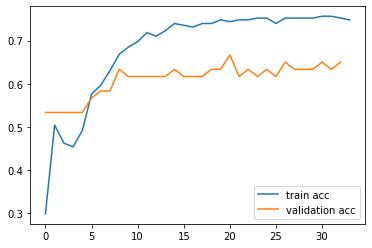

In [54]:
plt.plot(train_acc_arr, label='train acc')
plt.plot(val_acc_arr, label='validation acc')
plt.legend()
plt.show()

In [62]:
#for body only-
test_loss=0
test_acc=0
for inputs, labels in test_dataloader:

  pred=model1(inputs.flatten())
  pred=pred.unsqueeze(0)
  pred_hard=pred.argmax()
  loss = loss_func(pred, labels)
  test_loss+= loss.item()
  test_acc+=torch.sum((pred_hard== labels)[:].int()).item()
test_loss=test_loss/len(test_dataset)
print('test error=',test_loss)
test_acc=test_acc/len(test_dataset)
print('test_accuracy',test_acc)

d:\SOFTWARE\Anaconda3\envs\ece1786\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


test error= 1.4753619354704153
test_accuracy 0.23529411764705882


In [65]:
#for title only-
test_loss=0
test_acc=0
for inputs, labels in test_dataloader:

  pred=model1(inputs.flatten())
  pred=pred.unsqueeze(0)
  pred_hard=pred.argmax()
  loss = loss_func(pred, labels)
  test_loss+= loss.item()
  test_acc+=torch.sum((pred_hard== labels)[:].int()).item()
test_loss=test_loss/len(test_dataset)
print('test error=',test_loss)
test_acc=test_acc/len(test_dataset)
print('test_accuracy',test_acc)

d:\SOFTWARE\Anaconda3\envs\ece1786\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


test error= 1.5200935222608658
test_accuracy 0.16879795396419436


In [67]:
#for Both-
test_loss=0
test_acc=0
for inputs, labels in test_dataloader:

  pred=model1(inputs.flatten())
  pred=pred.unsqueeze(0)
  pred_hard=pred.argmax()
  loss = loss_func(pred, labels)
  test_loss+= loss.item()
  test_acc+=torch.sum((pred_hard== labels)[:].int()).item()
test_loss=test_loss/len(test_dataset)
print('test error=',test_loss)
test_acc=test_acc/len(test_dataset)
print('test_accuracy',test_acc)

d:\SOFTWARE\Anaconda3\envs\ece1786\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


test error= 1.4671178030235994
test_accuracy 0.2531969309462916


In [68]:
torch.save(model1.state_dict(), 'Baseline_multiclass.pt')

#unfreezing the embeddings

In [23]:
class CNNModel_unfrozen(torch.nn.Module): # CNN unfrozen model
    def __init__(self, vocab, n1,n2, k1,k2):
        super().__init__()
        # initialize word vectors to random numbers 
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors,freeze= False)
        self.conv1=torch.nn.Conv2d(1,n1,(100,k1),bias=False)
        self.conv2=torch.nn.Conv2d(1,n2,(100,k2),bias=False)
        self.activate=torch.nn.ReLU()
        self.maxpool= torch.nn.MaxPool2d((1,500),ceil_mode=True)
        #self.maxpool2= torch.nn.MaxPool1d()
        self.dropout = torch.nn.Dropout(0.25)
        self.out= torch.nn.Linear(n1+n2,1)
        #TO DO
        
        # prediction function takes embedding as input, and predicts which word in vocabulary as output

        #TO DO
        
    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        #TO DO
        #print(x.size())
        embed=self.embedding(x)
        #print(embed.size())
        embed=embed.T.unsqueeze(0)
        #print(embed.size())
        conv1=self.conv1(embed)
        conv1=self.activate(conv1)
        conv2=self.conv2(embed)
        conv2=self.activate(conv2)
        #conv1=conv1.squeeze()
        #conv2=conv2.squeeze()
        #print(conv1.size())
        #print(conv2.size())
        max1= self.maxpool(conv1)
        #print(max1.size())
        max2=self.maxpool(conv2)
        #print(max2.size())
        #drop=self.dropout(torch.cat((max1,max2)).squeeze())
        #output=self.out(drop)
        output=self.out(torch.cat((max1,max2)).squeeze())
        return output

In [24]:
model1=CNNModel_unfrozen(glove,25,25,2,3)

In [25]:
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
train_losses=[]
val_losses=[]
train_acc_arr=[]
val_acc_arr=[]

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    train_loss = 0.0
    val_loss=0
    train_acc=0
    val_acc=0
    model1.train()
    print('epoch=', epoch)
    
    for inputs, labels in train_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs.flatten())
        #print(outputs)
        #print(labels)
        loss = loss_func(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        train_acc+=torch.sum(((outputs>0)== labels)[:].int()).item()
    train_loss=train_loss/len(train_dataset)
    train_losses.append(train_loss)
    print('train loss=',train_loss)
    train_acc=train_acc/len(train_dataset)
    train_acc_arr.append(train_acc)
    print('train_acc',train_acc)


    model1.eval()
    for inputs, labels in validation_dataloader:

      pred=model1(inputs.flatten())
      loss = loss_func(pred, labels.float())
      val_loss+= loss.item()
      val_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
    val_loss=val_loss/len(val_dataset)
    val_losses.append(val_loss)
    print('validation error=',val_loss)
    val_acc=val_acc/len(val_dataset)
    val_acc_arr.append(val_acc)
    print('val_acc for epoch',val_acc)


print('Finished Training')
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_acc_arr, label='train acc')
plt.plot(val_acc_arr, label='validation acc')
plt.legend()
plt.show()

In [ ]:
test_loss=0
test_acc=0
for inputs, labels in test_dataloader:

  pred=model1(inputs.flatten())
  loss = loss_func(pred, labels.float())
  test_loss+= loss.item()
  test_acc+=torch.sum(((pred>0)== labels)[:].int()).item()
test_loss=test_loss/len(test_dataset)
print('test error=',test_loss)
test_acc=test_acc/len(test_dataset)
print('test_accuracy',test_acc)

In [ ]:
torch.save(model1.state_dict(), 'CNN.pt')

#extracting meaning from parameters

In [34]:
model = CNNModel(glove,25,25,2,3)
model.load_state_dict(torch.load('/content/CNN.pt'))
model.eval()

CNNModel(
  (embedding): Embedding(400000, 100)
  (conv1): Conv2d(1, 25, kernel_size=(100, 2), stride=(1, 1), bias=False)
  (conv2): Conv2d(1, 25, kernel_size=(100, 3), stride=(1, 1), bias=False)
  (activate): ReLU()
  (maxpool): MaxPool2d(kernel_size=(1, 500), stride=(1, 500), padding=0, dilation=1, ceil_mode=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [38]:
model.conv1.weight.squeeze()[0,:,0]

tensor([ 0.1355, -0.1392, -0.0869, -0.0755, -0.0955,  0.1125, -0.1065,  0.1090,
        -0.0488,  0.0208, -0.1225,  0.0027,  0.0869,  0.0462, -0.0112, -0.0886,
         0.1043,  0.0674, -0.0068, -0.1810, -0.1379, -0.0670,  0.0567, -0.0421,
        -0.0353, -0.0079, -0.1566, -0.1305,  0.0129,  0.0327,  0.0372, -0.0057,
        -0.0611,  0.0460, -0.0275, -0.0298, -0.1731,  0.0191, -0.0183, -0.0649,
        -0.1012,  0.0268,  0.1301, -0.0254, -0.0754, -0.0752,  0.0069,  0.0056,
         0.1513,  0.0310, -0.1507,  0.0961,  0.0438,  0.0921, -0.0474,  0.0071,
         0.0012, -0.2184, -0.0128,  0.0338, -0.0374,  0.0902, -0.0949,  0.0532,
         0.0780,  0.0177,  0.0671, -0.0158, -0.0343,  0.0342, -0.1083,  0.0009,
         0.0036, -0.1147, -0.2021,  0.1501, -0.1022, -0.1088, -0.0681,  0.0137,
         0.0427,  0.1664, -0.0510, -0.1159, -0.0649, -0.1552,  0.0214,  0.0251,
        -0.2108,  0.0079, -0.1293, -0.0769,  0.0505,  0.1267, -0.0956, -0.1218,
        -0.0861,  0.0385,  0.0122, -0.00

In [39]:
def print_closest_cosine_words(vec, n=5):
  dists = torch.cosine_similarity(glove.vectors.unsqueeze(0), vec.unsqueeze(0), dim=2).squeeze()
  dist_sort=torch.argsort(dists,descending=True)
  for idx in dist_sort[1:n+1]:
    print(glove.itos[idx], "\t%5.2f" % dists[idx])

In [41]:
for i in range(20):
  print("kernal-",i)
  print_closest_cosine_words(model.conv1.weight.squeeze()[i,:,0],5)

kernal- 0
their 	 0.48
schoolmates 	 0.45
mid-teens 	 0.44
classmates 	 0.44
returned 	 0.44
kernal- 1
kilkenny 	 0.42
pupate 	 0.38
offaly 	 0.38
their 	 0.38
capitalise 	 0.38
kernal- 2
kusuo 	 0.49
neena 	 0.49
sunita 	 0.48
luza 	 0.47
martorana 	 0.46
kernal- 3
cashed 	 0.44
returned 	 0.43
recontest 	 0.43
sabbatical 	 0.43
livings 	 0.42
kernal- 4
letterboxed 	 0.47
restrictively 	 0.47
outselling 	 0.47
flatteringly 	 0.44
digitised 	 0.44
kernal- 5
art-1stld 	 0.39
activists 	 0.39
pyrams 	 0.38
intelligencer 	 0.36
boersen 	 0.36
kernal- 6
pertained 	 0.40
delicacy 	 0.40
remiss 	 0.40
underpriced 	 0.40
cronulla-sutherland 	 0.40
kernal- 7
afterwards 	 0.47
confessed 	 0.46
www.caib.us 	 0.41
confesses 	 0.40
relents 	 0.40
kernal- 8
predictably 	 0.48
crucially 	 0.47
seldom 	 0.47
flatteringly 	 0.46
readily 	 0.46
kernal- 9
planner 	 0.43
heli 	 0.41
patrolman 	 0.41
muhtar 	 0.40
wc2003-rsa 	 0.40
kernal- 10
slightest 	 0.57
anyhow 	 0.55
suppose 	 0.54
brainer 	 0.54
he